# Assessment: Weekly deliverable template - Regression
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [9]:
import pandas as pd

df = pd.read_csv('wines_SPA.csv')

# I have done some data analysis previously, and I am aware there are also categorical variables.
# However, I understand from the grading scheme that the focus is more on the models and the evaluation 
# than on data preparation.
# Therefore, I will not perform any encoding of categorical variables at this stage.
# Neither will I impute any missing data, but simply drop rows with missing data.

# Only keep numeric columns. 
# I need to drop the categorical columns first, otherwise dropna() will also remove rows with missing data 
# in categorical columns that have no missing data in numerical columns and hence should remain.
df = df[df.select_dtypes(include=['float64', 'int64']).columns]

# Drop rows with missing data.
df = df.dropna()

# Remove duplicate rows. I noticed there were a lot of them, and they could skew the results.
df = df.drop_duplicates()

# Display the statistical summary of the dataframe.
print(df.describe())


            rating   num_reviews        price         body      acidity
count  1777.000000   1777.000000  1777.000000  1777.000000  1777.000000
mean      4.412043    544.481711   148.879392     4.258863     2.921216
std       0.151052   1380.719629   289.323828     0.652836     0.334713
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.300000     56.000000    33.030000     4.000000     3.000000
50%       4.400000    134.000000    58.260000     4.000000     3.000000
75%       4.500000    499.000000   125.000000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000


**Observations:**  

The remaining dataset has 1,777 examples.

*rating*

The rating values have a range between 4.2 and 4.9. Having done some analysis previously I can say that removing the duplicates has dramatically improved the distribution of values. The 75% quartile was at 4.2 (the minimum!), and is now at 4.5. Adding/substracting the std to/from the mean shows that 68% of examples have a rating between 4.3 and 4.6, and 95% of examples have rating below 4.8. From these data I expect a reasonably good distribution at a location of 4.4, the median. Rating seems a classic target attribute, as businesses may want to predict customer rating based on a range of criteria, and indirectly (as a proxy label) sales success. I am assuming that "Quality" (from later in the sheet) refers to the "rating" variable. If used as a feature, normalisation is not necessarily required due to the moderate values, but can be done with a standard approach. 

*num_reviews*

From the name I infer that this is the number of available reviews that lead to the "rating". The range is very high between 25 and 32.624. However, the 25% and 75% quartiles are at 56 and 499, respectively. This means that 50% of examples have review numbers in this range. The location is skewed to lower values. The standard deviation is quite high though. Only 68% of examples will have review numbers below mean+std = 1890, and 95% are below mean+2*std = 3243. (I'm ignoring the bottom because the minimum value is higher than mean-std.) This suggest we definitely can see some outliers at the top end (32,624). Simply looking at the magnitudes of numbers I am thinking of a logarithmic curve. Possibly a logarithmic normalisation may be a good approach here as I expect the data to be right-skewed - as is also intuitively expected considering that only few wines will have very high numbers of ratings. 

*price*

We see similar behaviour of the price data: A huge range (4.99–3119.08), a relatively strong 25-75% range (33.015-125) that is located at the lower price range, and again a very high standard deviation that shows that only 68% of examples have a price below 438.19, while 95% have a price below 727.59. The expectation again is to have some outliers at the top end. Again for normalisation, a logarithmic approach may be indicated, maybe even when price is the label. As for correlation analysis it may be an interesting question if the price correlates to rating in some way. Also, the expectation is that the number of reviews is higher towards the lower end of the price range. 

*body*

The range for body is between 2.0 and 5.0, and we don't see any decimals. This could mean this body is likely determined as a rating between 1 and 5. the 25% quartile is at 4. This means that the more than 75% of examples has a body value of 4 or 5, i.e. one of two values. This means the informational content of this attribute is questionable.

*acidity*

For acidity the case is even more extreme: mean-2*std is at 2.25, so 95% of examples have as value 3 (the maximum value). This attribute we can ignore as there is no informational content. 

### 2. At least two exploratory graphs with captions



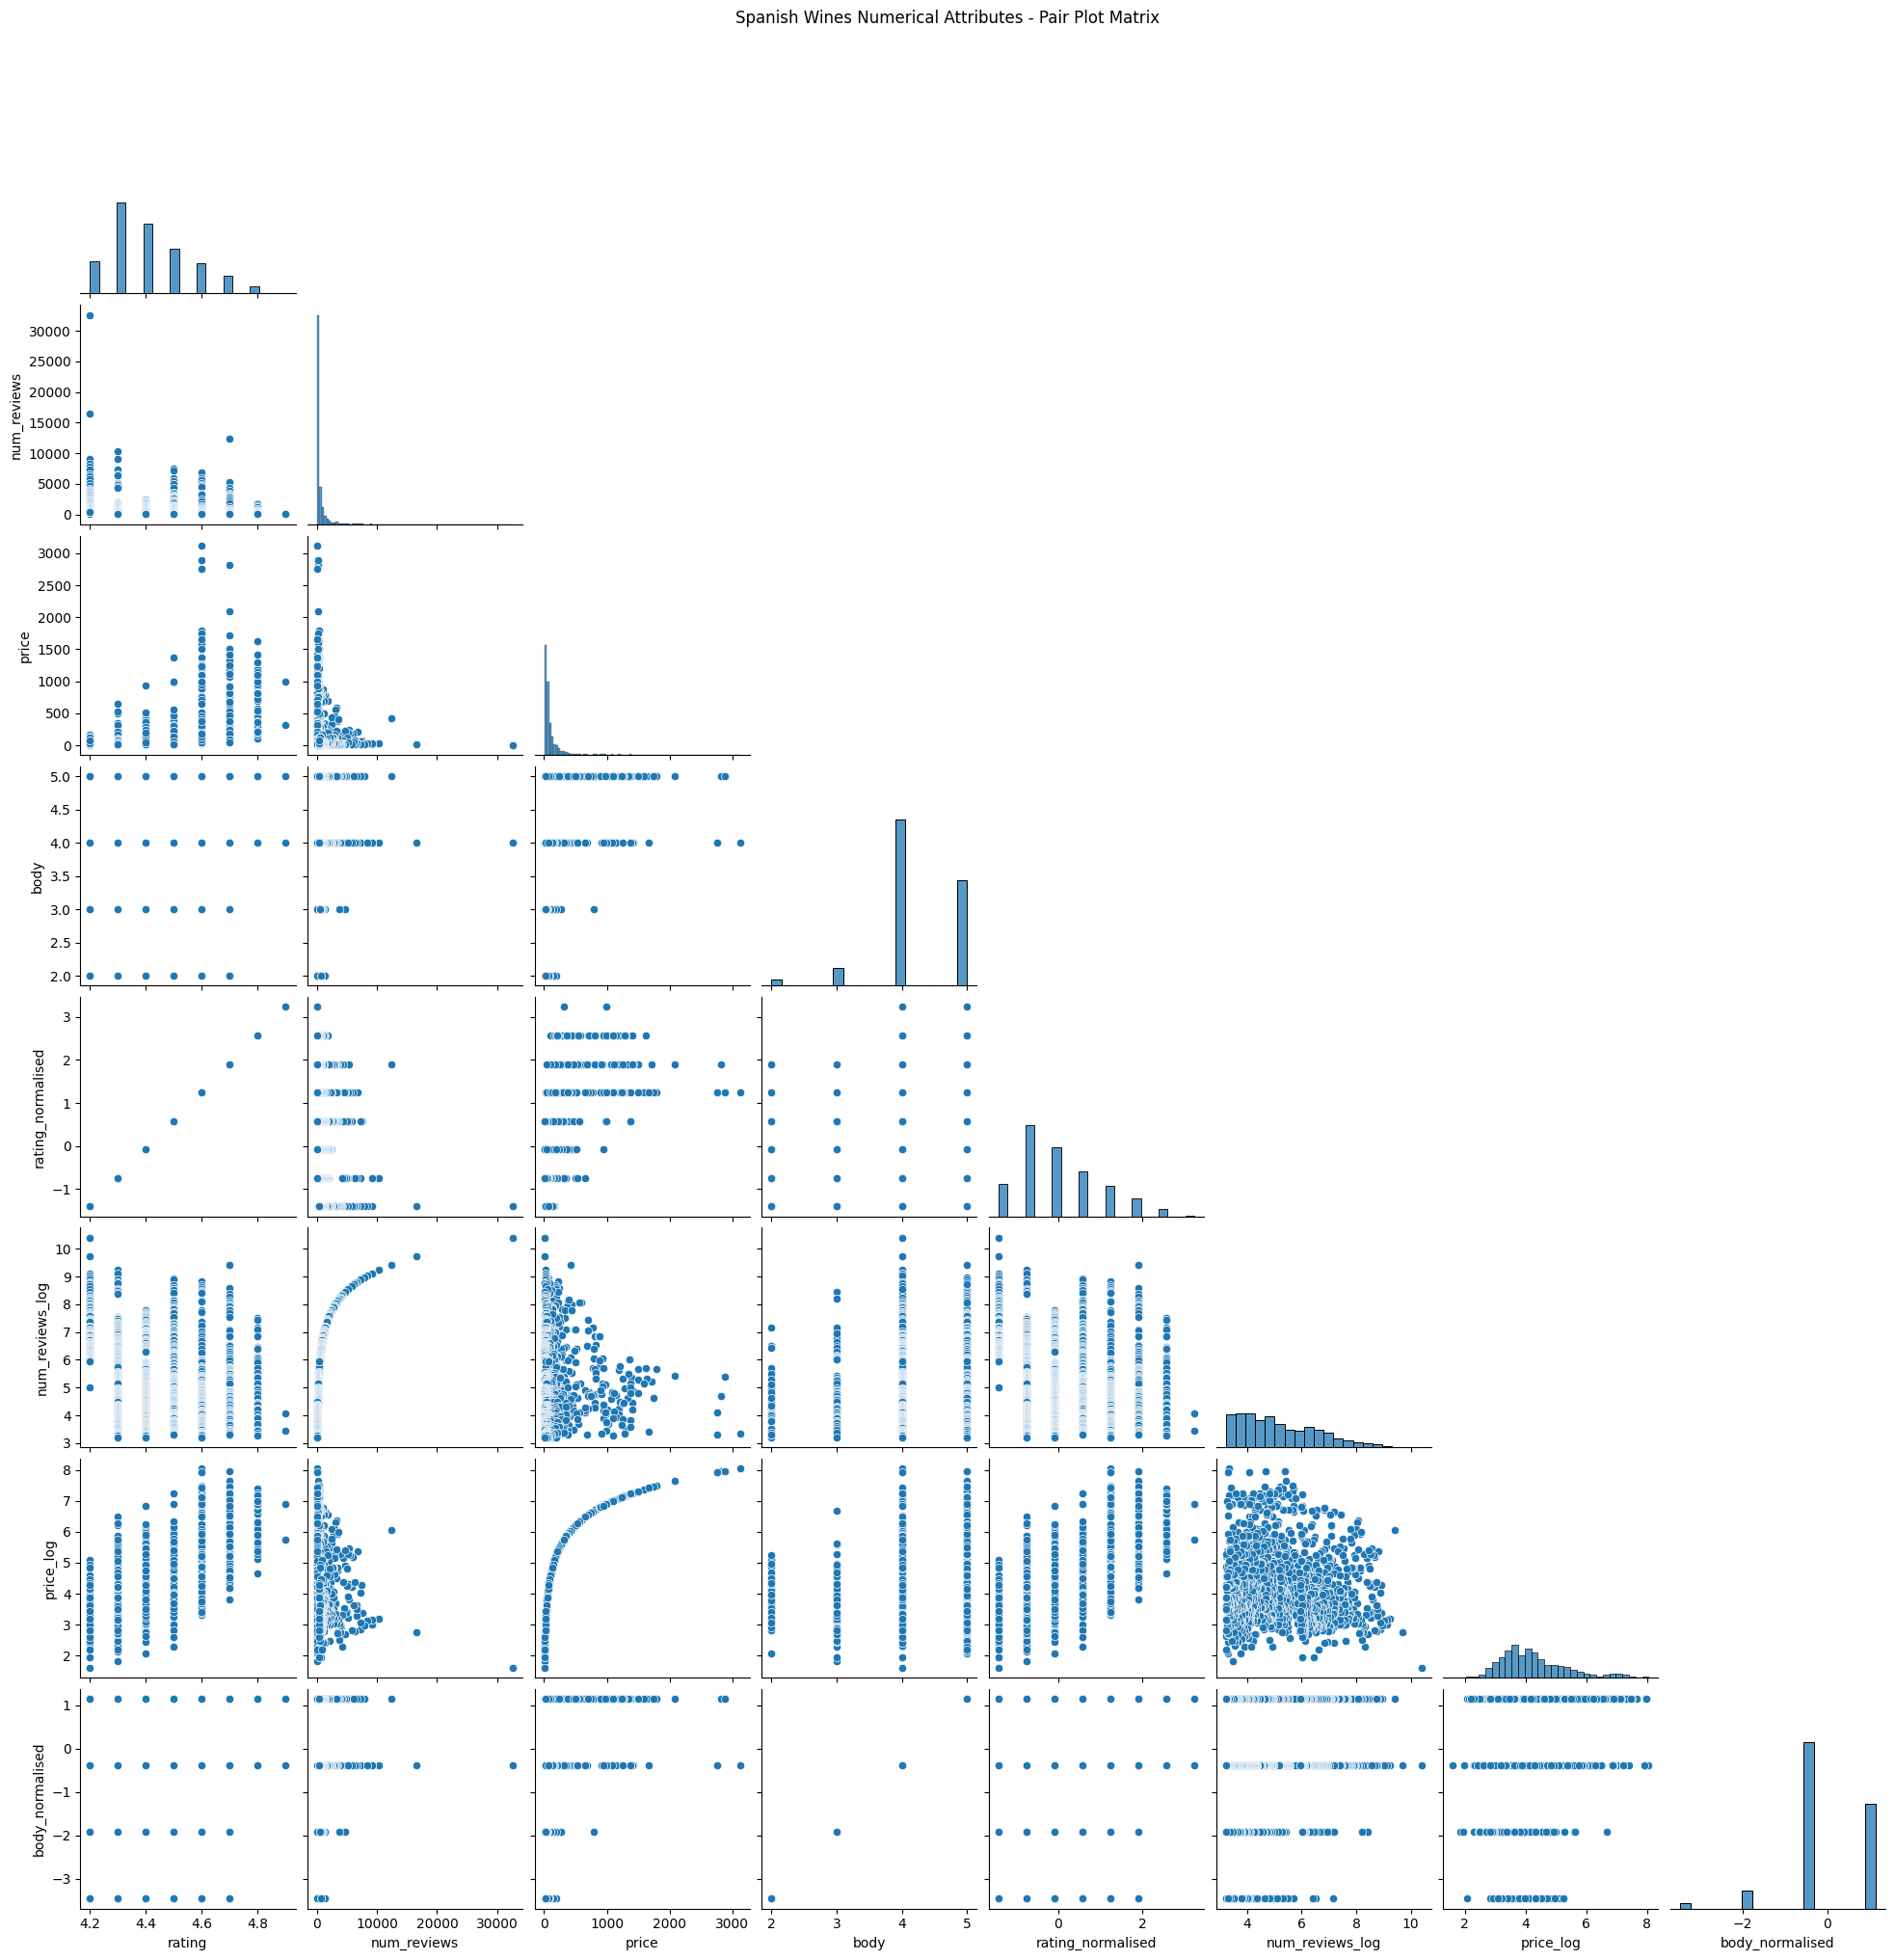

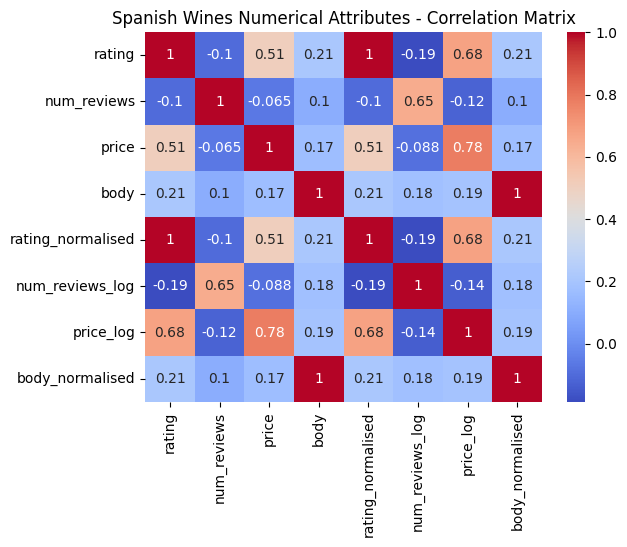

In [17]:
# drop acidity column
#df = df.drop(columns=['acidity'])

# Add a normalised version of the rating column.
df['rating_normalised'] = (df['rating'] - df['rating'].mean()) / df['rating'].std()

# Add a logarithmic version of the num_reviews column.
import numpy as np
df['num_reviews_log'] = df['num_reviews'].apply(lambda x: np.log(x))

# Add a logarithmic version of the price column.
df['price_log'] = df['price'].apply(lambda x: np.log(x))

# Add a normalised version of the body column.
df['body_normalised'] = (df['body'] - df['body'].mean()) / df['body'].std()


# Show a pairplot of the dataframe.
import matplotlib.pyplot as plt
import seaborn as sns    

sns.pairplot(df,
             corner=True
             )
plt.suptitle("Spanish Wines Numerical Attributes - Pair Plot Matrix", y=1.02)
plt.show()

# Show the correlation matrix of the dataframe.
sns.heatmap(df.corr(), 
            annot=True, 
            cmap='coolwarm'
            )
plt.title("Spanish Wines Numerical Attributes - Correlation Matrix")
plt.show()

**Observations:**  

Immediately the **histograms** confirm the assumptions from the statistical data: *num_reviews* and *price* are heavily right-skewed. Rating only shows a light imbalance, which I don't find problematic as it matches the expectation in reality that most wines don't get the highest ratings. *Body* is very dominant on two values, but there is something resembling a normal distribution. However, I am still not sure how much informational content is in the value. 

I am surprised how well the **logarithmic normalisation** works for *price* and *num_reviews*. *num_reviews* is now much more evenly distributed, and *price* has a very good normal distribution now, with a small second maximum in a higher price range. I would expect if I were to look into wine types or year, this may clarify this second peak for more expensive wines. 

There are some **outliers** certainly in the *price* and *num_ratings* variables which may skew the result. I will remove the example that has > 20,000 *num_reviews*. As for *price* there seem to be 5 examples that are outliers. I could clip them or drop them. For simplicity I will drop the examples with a *price* > 2,500. 

As for the **pair plots**, *price_log* vs. *rating*/*rating_normalised* catch the eye and should give a good correlation. Other than that, nothing stands out. 

This is confirmed by the **correlation matrix**. It is interesting to see how the correlation rises between *rating* and *price* (0.51) vs. *price_log* (0.68). 



### 3. Histogram showing rating imbalance (if any)


In [ ]:
# ---- Your code here ----

**Observations:**  

### 4. Price-regression model + metrics + plot


In [ ]:
# ---- Your code here ----

**Observations:**  

### 5. Quality-regression model + metrics + plot


In [ ]:
# ---- Your code here ----

**Observations:**  

### 6. Over/under-fitting discussion and fix

In [ ]:
# ---- Your code here ----

**Observations:**  

### 7. Apply cross-validation or statistical analyses on the features or results of the regression models (advanced)

In [ ]:
# ---- Your code here ----

**Observations:**  